# Liveness-Tracking Results

Here are the results for the liveness tests.

## 1. Imports

Import the libraries to process the data

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
from math import prod
import os

## 2. Read Data

Read in the data for each test result.

In [67]:
# The data is stored in a 5XX.csv for the serial tests, and 6XX.csv for the parallel tests
# The data files are in the `/data` folder

# Check if the data is loaded
# If not, load it
if 'all_data' in locals():
    print("Data already loaded")
else:
    # A structure for storing the data
    all_data = {}

    for i in range(500, 600):
        if os.path.isfile("../data/object-liveness-test/" + str(i) + ".csv"):
            all_data[i] = pd.read_csv("../data/object-liveness-test/" + str(i) + ".csv")
            print("Loaded data for test " + str(i))

Data already loaded


In [68]:
class Object:
    def __init__(self, allocation):
        self.allocation = allocation
        self.data = []
        

    def __hash__(self):
        # An object is uniquely identified by its allocation address, and the intervals it was alive for
        return hash((self.allocation.address, self.get_first_interval(), self.get_last_interval()))
    
    def get_address(self):
        return self.allocation.address

    def get_site(self):
        return self.allocation.site

    def was_written_to_during_interval(self, interval):
        '''
        Was this object written to during the given interval
        '''
        # return sum([int(row["Written During This Interval?"]) for row in self.data if row["Interval #"] == interval])
        first_interval_alive = self.get_first_interval()
        if interval < first_interval_alive or interval > self.get_last_interval():
            return False
        interval = self.data[interval - first_interval_alive]
        return interval["Written During This Interval?"]

    def get_data_after_last_write(self):
        '''
        Get the data after the last write to this object

        If the object was never written to, this will return the entire data
        '''
        result = []
        for row in self.data:
            if row["Written During This Interval?"]:
                result = []
            else:
                result.append(row)
        assert sum([1 for row in result if row["Written During This Interval?"]]) == 0
        last_write = self.get_interval_of_last_write()
        assert len(result) == 0 or result[0]["Interval #"] == last_write + 1 or last_write == -1
        return result
    
    def get_data_for_longest_lifetime_without_write(self):
        '''
        Get the data for the longest lifetime without a write to this object

        If this object was always written to, this will return an empty list
        '''

        longest_contiguous = 0
        current_contiguous = 0

        result = []
        for i, row in enumerate(self.data):
            if not row["Written During This Interval?"]:
                current_contiguous += 1
            else:
                if current_contiguous > longest_contiguous:
                    result = self.data[i-current_contiguous:i]
                    longest_contiguous = current_contiguous

                current_contiguous = 0

        if current_contiguous > longest_contiguous:
            result = self.data[-current_contiguous:]
            longest_contiguous = current_contiguous


        assert len(result) == self.get_longest_lifetime_without_write()
        assert len(result) == longest_contiguous
        assert sum([1 for row in result if row["Written During This Interval?"]]) == 0

        return result


    def get_average_compression_savings_in_bytes(self):
        '''
        Get the average amount of memory saved by compressing the physical pages in bytes
        '''
        # avg = 0
        # for row in self.data:
        #     interval_savings = row["Object Physical Page Compression Savings (bytes)"]
        #     avg += interval_savings
        # return avg / len(self.data)
        return sum([row["Object Physical Page Compression Savings (bytes)"] for row in self.data]) / max(1, len(self.data))
    
    def get_average_compression_savings_after_last_write_in_bytes(self):
        '''
        Get the amount of memory saved by compressing the physical pages after the last write in bytes
        '''
        data_after_last_write = self.get_data_after_last_write()
        # savings = 0
        # for row in data_after_last_write:
        #     savings += row["Object Physical Page Compression Savings (bytes)"]
        # if savings == 0 or len(data_after_last_write) == 0:
        #     return 0
        # savings /= len(data_after_last_write)
        return sum([row["Object Physical Page Compression Savings (bytes)"] for row in data_after_last_write]) / max(1, len(data_after_last_write))
    
    def get_average_compression_during_longest_lifetime_without_write_in_bytes(self):
        '''
        Get the average amount of memory saved by compressing the physical pages during the longest lifetime without a write in bytes
        '''
        data = self.get_data_for_longest_lifetime_without_write()
        if len(data) == 0:
            return 0
        return sum([row["Object Physical Page Compression Savings (bytes)"] for row in data]) / max(1, len(data))

    def get_virtual_size_in_bytes(self):
        '''
        Get the size of virtual memory occupied by the object in bytes
        '''
        return self.data[0]["Object Virtual Size (bytes)"]

    def get_physical_size_in_bytes(self):
        '''
        Get the size of physical pages occupied by the object in bytes
        '''
        return self.data[-1]["Object Physical Size (bytes)"]
    
    def get_first_interval(self):
        '''
        Get the first interval this object was alive for
        '''
        return self.data[0]["Interval #"]
    
    def get_last_interval(self):
        '''
        Get the last interval this object was alive for
        '''
        return self.data[-1]["Interval #"]
    
    def get_lifetime_intervals(self):
        '''
        How long did this object live for (in intervals)
        '''
        # Get the maximum age of the object
        return len(self.data)
    
    def get_total_intervals_with_write(self):
        '''
        Get the total number of intervals this object was written to
        '''
        return sum([1 for row in self.data if row["Written During This Interval?"]])

    def get_total_intervals_without_write(self):
        '''
        Get the total number of intervals this object was not written to
        '''
        return sum([1 for row in self.data if not row["Written During This Interval?"]])

    def get_interval_of_last_write(self, interval=None):
        '''
        Get the interval number of the last write to this object

        If the object was never written to, this will return -1
        '''
        if interval is not None:
            for row in self.data[::-1]:
                if row["Interval #"] <= interval and row["Written During This Interval?"]:
                    return row["Interval #"]
            return -1

        for row in self.data[::-1]:
            if row["Written During This Interval?"]:
                return row["Interval #"]
        return -1
    
    def get_longest_lifetime_without_write(self):
        '''
        Get the longest number of continuous intervals without a write to this object
        '''
        longest = 0
        current = 0
        for row in self.data:
            if not row["Written During This Interval?"]:
                current += 1
            else:
                longest = max(longest, current)
                current = 0
        return max(longest, current)
    
    def get_lifetime_after_last_write(self):
        '''
        Get the number of intervals this object lived for after the last write

        If the object was never written to, this will return the same as `get_lifetime_intervals`
        '''
        if self.get_interval_of_last_write() == -1:
            return self.get_lifetime_intervals()
        return self.get_last_interval() - self.get_interval_of_last_write()

    def add_row(self, row):
        self.data.append(row)

    def __str__(self):
        result = "Object: " + str(self.allocation.address) + "\n"
        result += "  Allocation Site: " + str(self.allocation.site) + "\n"
        result += "  Size:\n"
        result += "    Virtual: " + str(self.get_virtual_size_in_bytes()) + " bytes\n"
        result += "    Physical: " + str(self.get_physical_size_in_bytes()) + " bytes\n"
        result += "    Avg. physical compression savings throughout lifetime: " + str(self.get_average_compression_savings_in_bytes()) + " bytes\n"
        result += "    Avg. physical compression savings after last write: " + str(self.get_average_compression_savings_after_last_write_in_bytes()) + " bytes\n"
        result += "    Avg. physical compression savings throughout longest clean streak: " + str(self.get_average_compression_during_longest_lifetime_without_write_in_bytes()) + " bytes\n"
        result += "  First interval: " + str(self.get_first_interval()) + "\n"
        result += "  Last interval: " + str(self.get_last_interval()) + "\n"
        result += "  Lifetime: " + str(self.get_lifetime_intervals()) + "\n"
        result += "  Interval of last write: " + str(self.get_interval_of_last_write()) + "\n"
        result += "  Longest lifetime without write: " + str(self.get_longest_lifetime_without_write()) + "\n"
        result += "  Lifetime after last write: " + str(self.get_lifetime_after_last_write()) + "\n"
        result += "  Total intervals with write: " + str(self.get_total_intervals_with_write()) + "\n"
        result += "  Total clean intervals: " + str(self.get_total_intervals_without_write()) + "\n"
        return result

    def __repr__(self):
        return str(self.get_address()) + " [Interval #" + str(self.get_first_interval()) + " - #" + str(self.get_last_interval()) + "]"

class Address:
    def __init__(self, address, site):
        self.address = address
        self.site = site
        self.associated_objects = []

    def get_objects(self):
        return self.associated_objects

    def add_row(self, row):
        if row["Is new?"]:
            self.associated_objects.append(Object(self))
        self.associated_objects[-1].add_row(row) 

    def __str__(self):
        result = "Address: " + str(self.address) + "\n"
        for obj in self.associated_objects:
            result += str(obj) + "\n"
        return result

    def __repr__(self):
        return str(self)

## 3. Process Results

Go through the data and process some results.

## 3.1 New, Stale, and Hot Allocations

This graphs the number of live objects each iteration, the number of new objects allocated that iteration, and the objects that were written to that iteration. The ages of the objects are also denoted by the color, and the brightness indicates the compression savings.

### 3.1.1 Divide the data into information about each object

In [69]:
if 'tests' in locals() and 'test_allocation_data' in locals():
    print("Tests already loaded")
else:
    # Get the tests from the data
    tests = list(all_data.keys())
    # Get the number of tests
    print("Number of tests: " + str(len(tests)))

    test_allocation_data = {}

    # Iterate over the tests and graph the results
    for test in tests:
        # Get the data for the test
        test_data = all_data[test]

        # For each test interval, make the data keyed on each object's address.
        # If it is reallocated (its "Is new?" column is set), treat it as a new allocation.
        allocation_data = {}
        for index, row in test_data.iterrows():
            address = row["Object Address"]
            site = row["Allocation Site"]
            if address not in allocation_data:
                allocation_data[address] = Address(address, site)
            allocation_data[address].add_row(row)

        # Store the allocation data for this test
        test_allocation_data[test] = allocation_data

    for test_number, allocation_data in test_allocation_data.items():
        print("Test " + str(test_number))
        for address, address_data in allocation_data.items():
            print(str(address_data))

Tests already loaded


### 3.1.2 Graph the data

Test 500
Total objects for intervals: [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 25]
Total written for intervals: [6, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 14, 15, 16, 17, 16, 18, 18, 20, 21, 15]
Total new for intervals: [6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
Tracked 25 objects
Sorting objects by size and truncating to 250...
20.0% done
40.0% done
60.0% done
80.0% done
100.0% done
Done processing data for test 500
Graphing data...
Done with sixth graph, moving on to the next...


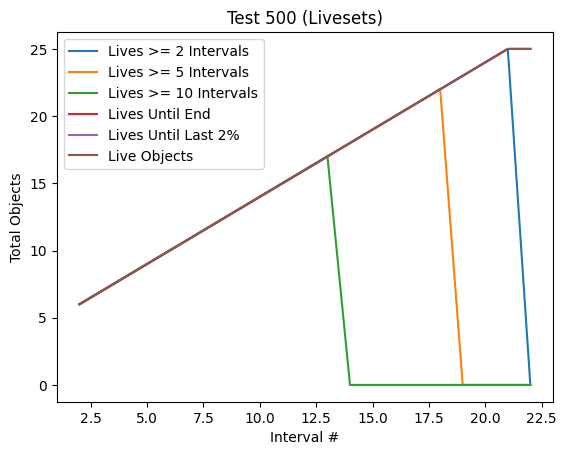

Test 501
Total objects for intervals: [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 25]
Total written for intervals: [6, 4, 5, 5, 6, 7, 8, 8, 9, 9, 9, 9, 10, 10, 12, 11, 12, 12, 13, 13, 4]
Total new for intervals: [6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
Tracked 25 objects
Sorting objects by size and truncating to 250...
20.0% done
40.0% done
60.0% done
80.0% done
100.0% done
Done processing data for test 501
Graphing data...
Done with sixth graph, moving on to the next...


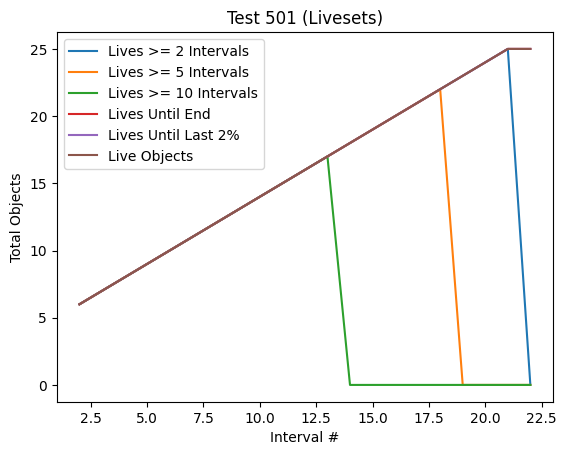

Test 502
Total objects for intervals: [942, 1288, 1429, 1556, 1771, 1869, 1876, 1893, 1931, 1906, 1922, 1943, 1964, 2006, 2013, 2011, 2013, 2013, 2013, 2013, 2013, 2013]
Total written for intervals: [942, 1288, 1359, 1393, 1541, 1366, 1239, 1260, 1156, 1183, 1208, 1210, 1321, 1185, 1184, 1265, 1229, 1049, 1216, 1212, 1082, 1133]
Total new for intervals: [942, 354, 149, 185, 232, 112, 10, 17, 48, 18, 20, 21, 24, 47, 26, 14, 6, 3, 3, 6, 1, 0]
Tracked 2238 objects
Sorting objects by size and truncating to 250...
10.0% done
20.0% done
30.0% done
40.0% done
50.0% done
60.0% done
70.0% done
80.0% done
90.0% done
100.0% done
Done processing data for test 502
Graphing data...
Done with sixth graph, moving on to the next...


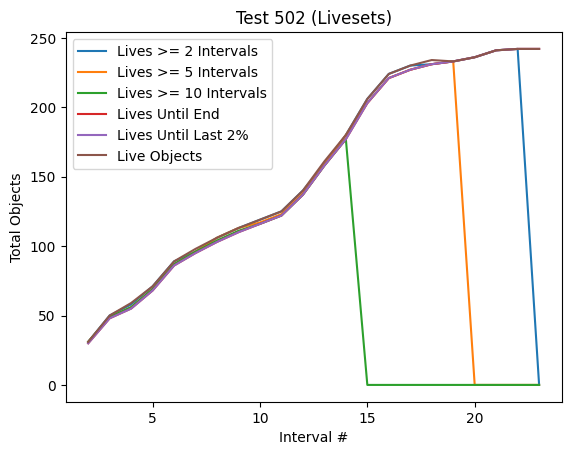

Test 505
Total objects for intervals: [10, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1010, 10, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1010, 10, 1011, 1011]
Total written for intervals: [10, 1011, 135, 135, 135, 135, 135, 135, 135, 135, 10, 1011, 134, 135, 135, 135, 135, 135, 135, 135, 10, 1011, 135]
Total new for intervals: [10, 1006, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1006, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1004, 0]
Tracked 3032 objects
Sorting objects by size and truncating to 250...
10.0% done
20.0% done
30.0% done
40.0% done
50.0% done
60.0% done
70.0% done
80.0% done
90.0% done
100.0% done
Done processing data for test 505
Graphing data...
Done with sixth graph, moving on to the next...


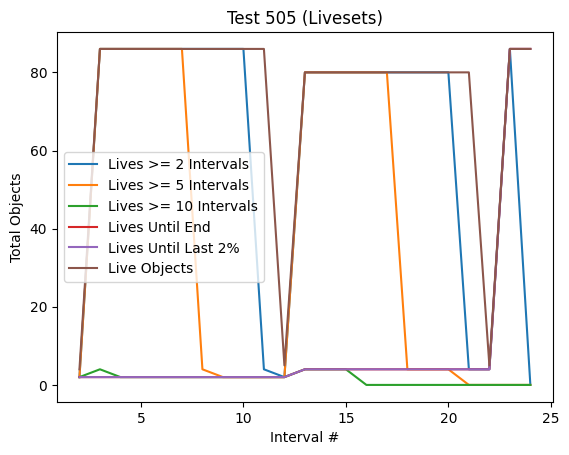

Test 507
Total objects for intervals: [884, 1384, 1822]
Total written for intervals: [884, 712, 734]
Total new for intervals: [884, 500, 438]
Tracked 1822 objects
Sorting objects by size and truncating to 250...
10.0% done
20.0% done
30.0% done
40.0% done
50.0% done
60.0% done
70.0% done
80.0% done
90.0% done
100.0% done
Done processing data for test 507
Graphing data...
Done with sixth graph, moving on to the next...


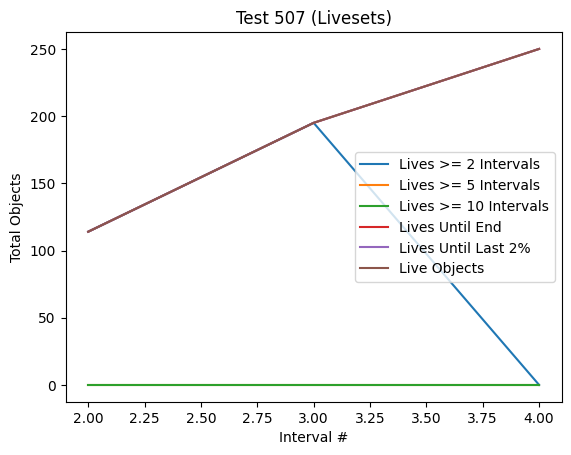

Test 508
No objects to process for test 508
Test 510
Total objects for intervals: [465, 594, 637, 645]
Total written for intervals: [465, 593, 604, 592]
Total new for intervals: [465, 131, 47, 10]
Tracked 653 objects
Sorting objects by size and truncating to 250...
10.0% done
20.0% done
30.0% done
40.0% done
50.0% done
60.0% done
70.0% done
80.0% done
90.0% done
100.0% done
Done processing data for test 510
Graphing data...
Done with sixth graph, moving on to the next...


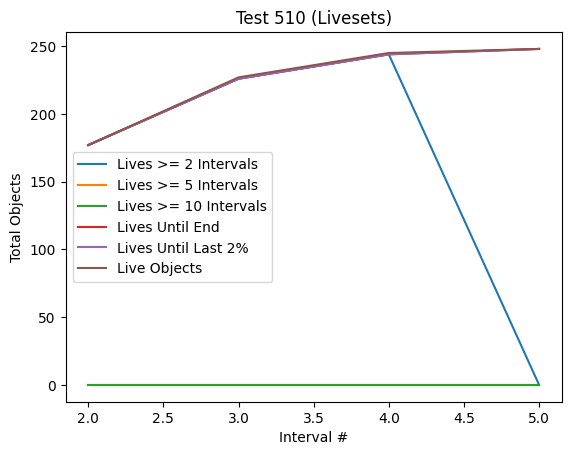

Test 511
Total objects for intervals: [490, 252, 686, 1433, 1760, 1773, 2282]
Total written for intervals: [490, 244, 676, 1162, 1100, 754, 1327]
Total new for intervals: [490, 7, 436, 747, 337, 60, 528]
Tracked 2605 objects
Sorting objects by size and truncating to 250...
10.0% done
20.0% done
30.0% done
40.0% done
50.0% done
60.0% done
70.0% done
80.0% done
90.0% done
100.0% done
Done processing data for test 511
Graphing data...
Done with sixth graph, moving on to the next...


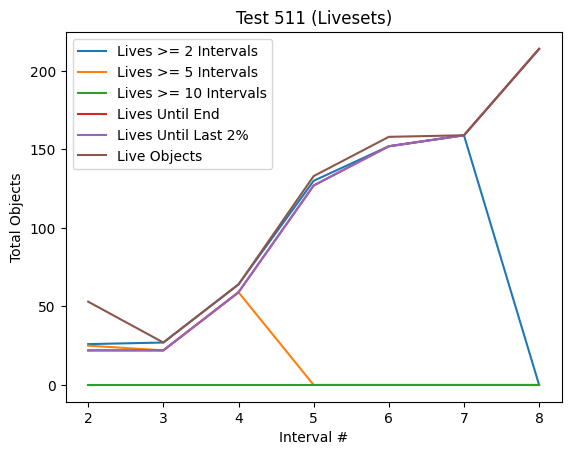

Test 519
Total objects for intervals: [4, 2]
Total written for intervals: [4, 1]
Total new for intervals: [4, 0]
Tracked 4 objects
Sorting objects by size and truncating to 250...
50.0% done
100.0% done
Done processing data for test 519
Graphing data...
Done with sixth graph, moving on to the next...


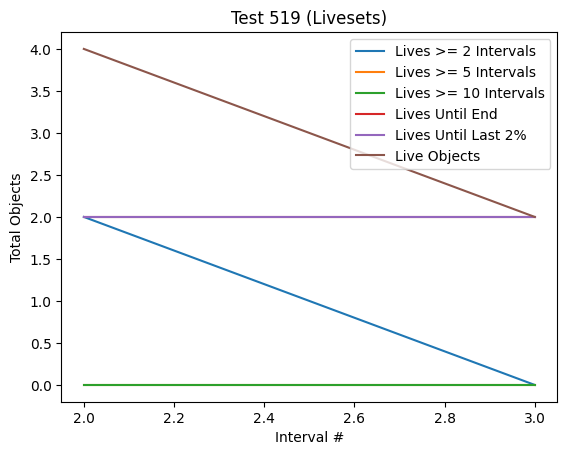

Test 520
Total objects for intervals: [767, 939, 1003]
Total written for intervals: [767, 477, 483]
Total new for intervals: [767, 174, 70]
Tracked 1011 objects
Sorting objects by size and truncating to 250...
10.0% done
20.0% done
30.0% done
40.0% done
50.0% done
60.0% done
70.0% done
80.0% done
90.0% done
100.0% done
Done processing data for test 520
Graphing data...
Done with sixth graph, moving on to the next...


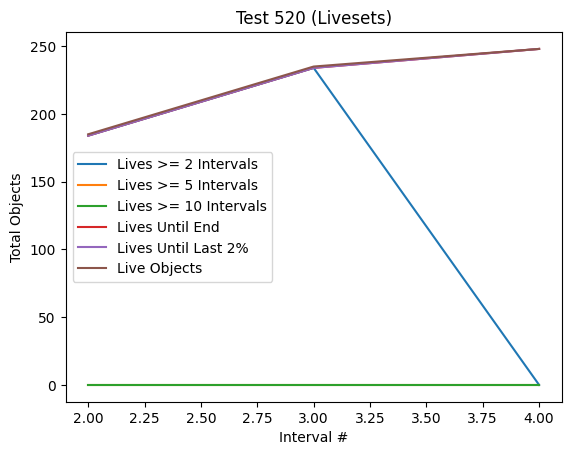

Test 521
Total objects for intervals: [37, 40, 42, 46, 55, 57, 59, 61, 66, 69, 72, 78, 82, 85, 90, 92, 95, 98, 100, 102, 104, 105, 107, 109, 111, 112, 114, 116, 121, 123, 125, 128, 130, 133, 145, 149, 154, 167, 169, 175, 177, 191, 195, 197, 209, 213, 219, 231, 237, 241, 244, 249, 254]
Total written for intervals: [37, 16, 18, 22, 32, 27, 29, 31, 37, 38, 38, 45, 46, 49, 55, 54, 57, 60, 62, 64, 66, 67, 69, 71, 73, 74, 76, 78, 83, 85, 87, 90, 92, 96, 106, 98, 99, 110, 100, 104, 99, 114, 104, 101, 114, 106, 108, 114, 108, 109, 112, 117, 122]
Total new for intervals: [37, 3, 2, 4, 9, 2, 2, 2, 5, 3, 3, 6, 4, 3, 5, 2, 3, 3, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 5, 2, 2, 3, 2, 3, 12, 4, 5, 13, 2, 6, 2, 14, 4, 2, 12, 4, 6, 12, 6, 4, 3, 5, 5]
Tracked 254 objects
Sorting objects by size and truncating to 250...
10.0% done
20.0% done
30.0% done
40.0% done
50.0% done
60.0% done
70.0% done
80.0% done
90.0% done
100.0% done
Done processing data for test 521
Graphing data...
Done with sixth graph, moving on t

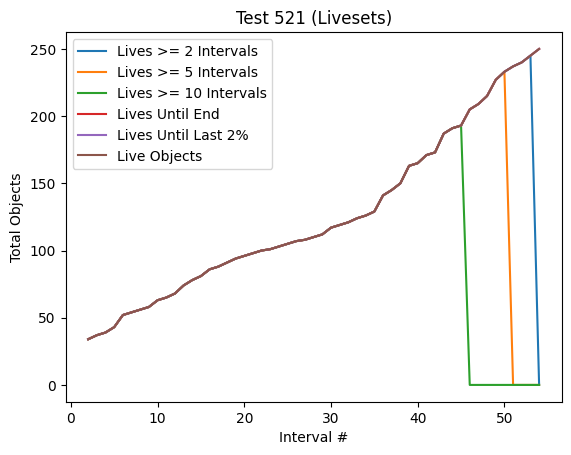

Test 523
Total objects for intervals: [954, 1014, 1012, 1012, 1012, 1012, 1012, 1012, 1012, 1012, 1012, 996, 994, 993, 994, 994, 994, 994, 994, 994, 994, 994, 994, 994, 994, 994, 994, 994, 994, 994, 994, 994, 994, 994, 994, 994, 994, 994, 994, 994, 994, 994, 994, 994, 994]
Total written for intervals: [954, 785, 699, 595, 595, 595, 723, 595, 593, 720, 581, 845, 841, 839, 835, 840, 834, 833, 833, 833, 833, 833, 833, 832, 833, 830, 831, 830, 830, 831, 831, 831, 831, 831, 830, 831, 831, 831, 830, 832, 831, 831, 831, 831, 831]
Total new for intervals: [954, 60, 0, 0, 0, 1, 1, 0, 0, 0, 0, 103, 3, 12, 1, 6, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tracked 1145 objects
Sorting objects by size and truncating to 250...
Error processing test 523: All arrays must be of the same length
Test 525
Total objects for intervals: [1008, 1009, 1009, 1009, 819]
Total written for intervals: [1008, 959, 1003, 816, 575]
Total new for intervals: [1008, 2, 0, 0, 0]


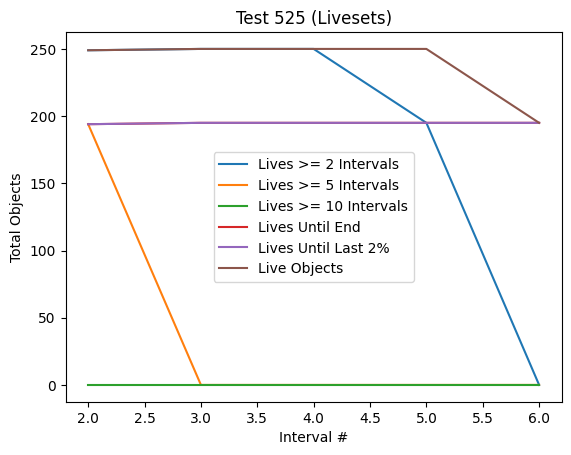

Test 526
Total objects for intervals: [1606, 2002, 2002, 2002, 2002, 2002, 2002, 2002, 2002, 2002, 2007, 2007, 2007, 2007, 2007, 2007, 2007, 2007, 2007, 2007, 2007, 2007]
Total written for intervals: [1606, 985, 606, 587, 587, 587, 587, 587, 584, 584, 589, 586, 586, 586, 586, 586, 586, 587, 585, 585, 585, 585]
Total new for intervals: [1606, 396, 0, 0, 0, 0, 3, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tracked 2010 objects
Sorting objects by size and truncating to 250...
10.0% done
20.0% done
30.0% done
40.0% done
50.0% done
60.0% done
70.0% done
80.0% done
90.0% done
100.0% done
Done processing data for test 526
Graphing data...
Done with sixth graph, moving on to the next...


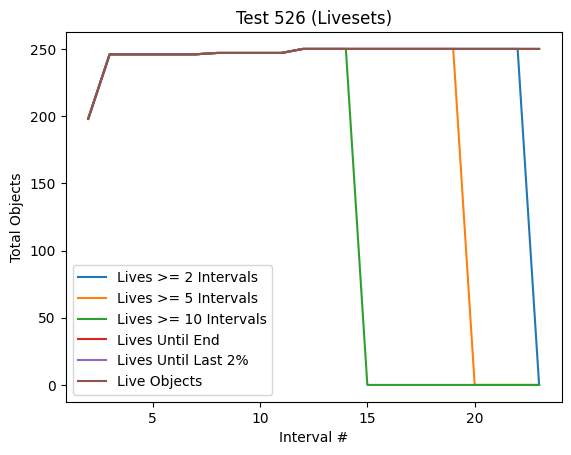

Test 527
Total objects for intervals: [70, 70, 70, 70, 70, 135, 135, 139, 139, 140, 393, 855, 857]
Total written for intervals: [70, 63, 63, 63, 63, 134, 71, 78, 75, 73, 335, 639, 275]
Total new for intervals: [70, 0, 0, 0, 0, 65, 3, 7, 3, 4, 256, 463, 11]
Tracked 882 objects
Sorting objects by size and truncating to 250...
10.0% done
20.0% done
30.0% done
40.0% done
50.0% done
60.0% done
70.0% done
80.0% done
90.0% done
100.0% done
Done processing data for test 527
Graphing data...
Done with sixth graph, moving on to the next...


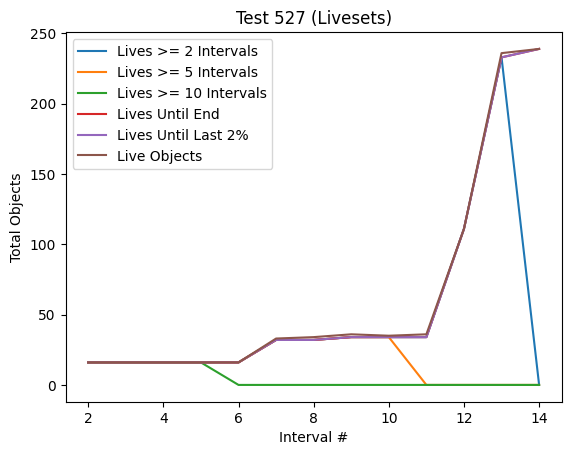

Test 531
Total objects for intervals: [4, 2]
Total written for intervals: [4, 2]
Total new for intervals: [4, 0]
Tracked 4 objects
Sorting objects by size and truncating to 250...
50.0% done
100.0% done
Done processing data for test 531
Graphing data...
Done with sixth graph, moving on to the next...


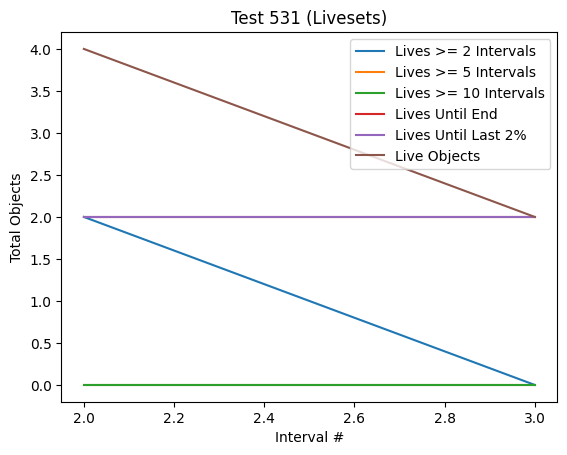

Test 538
Total objects for intervals: [437, 437, 437, 438, 438, 437, 437, 449, 450, 449, 76]
Total written for intervals: [437, 133, 133, 134, 134, 133, 133, 378, 114, 113, 74]
Total new for intervals: [437, 0, 0, 1, 1, 0, 0, 68, 1, 0, 0]
Tracked 508 objects
Sorting objects by size and truncating to 250...
10.0% done
20.0% done
30.0% done
40.0% done
50.0% done
60.0% done
70.0% done
80.0% done
90.0% done
100.0% done
Done processing data for test 538
Graphing data...
Done with sixth graph, moving on to the next...


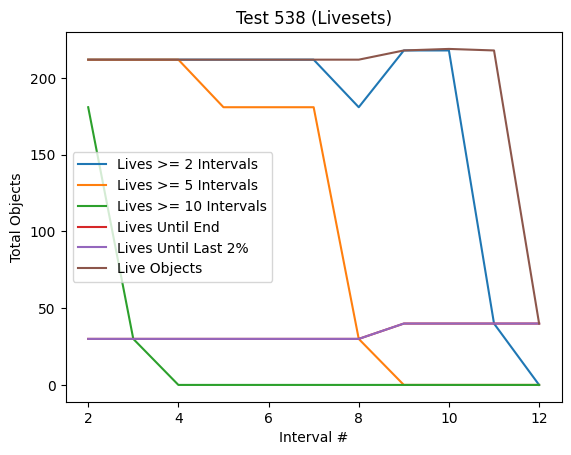

Test 541
Total objects for intervals: [753, 1259, 1115, 1141, 1142, 1141, 1143, 1848, 1477, 1476, 1476, 1480]
Total written for intervals: [753, 742, 80, 337, 394, 392, 394, 1469, 778, 585, 832, 831]
Total new for intervals: [753, 510, 2, 29, 2, 1, 3, 708, 3, 2, 2, 27]
Tracked 2042 objects
Sorting objects by size and truncating to 250...
10.0% done
20.0% done
30.0% done
Error processing test 541: All arrays must be of the same length
Test 544
Total objects for intervals: [130, 2230, 2773, 3850, 3850]
Total written for intervals: [130, 2228, 714, 1668, 166]
Total new for intervals: [130, 2100, 543, 1079, 0]
Tracked 3852 objects
Sorting objects by size and truncating to 250...
10.0% done
20.0% done
30.0% done
40.0% done
50.0% done
60.0% done
70.0% done
80.0% done
90.0% done
100.0% done
Done processing data for test 544
Graphing data...
Done with sixth graph, moving on to the next...


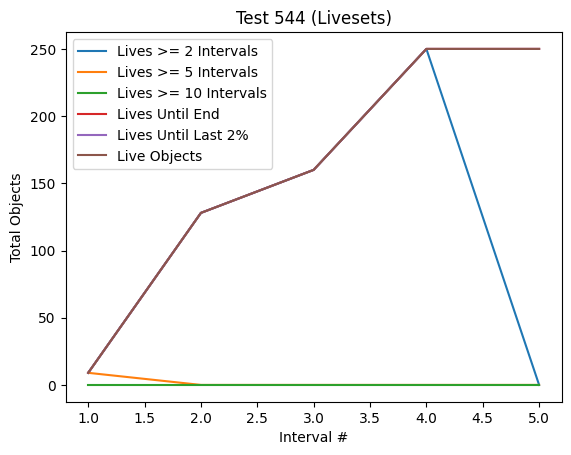

Test 548
Total objects for intervals: [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 12, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 9, 9, 9]
Total written for intervals: [9, 2, 1, 1, 3, 3, 2, 2, 3, 4, 4, 3, 3, 3, 7, 9, 8, 9, 9, 9, 8, 8, 8, 8, 9, 8, 8, 8, 8, 9, 9, 8, 8, 9, 9, 8, 8, 8, 9, 9, 9, 8, 9, 9, 12, 9, 8, 8, 8, 9, 8, 8, 8, 8, 9, 9, 9, 8, 8, 8, 10, 9, 8, 8, 8, 9, 9, 9, 8, 9, 9, 9, 10, 9, 8, 8]
Total new for intervals: [9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Tracked 14 objects
Sorting objects by size and truncating to 250...
50.0% done
100.0% done
Done processing data for test 548
Graphing data...
Done with sixth graph, moving on to the next...


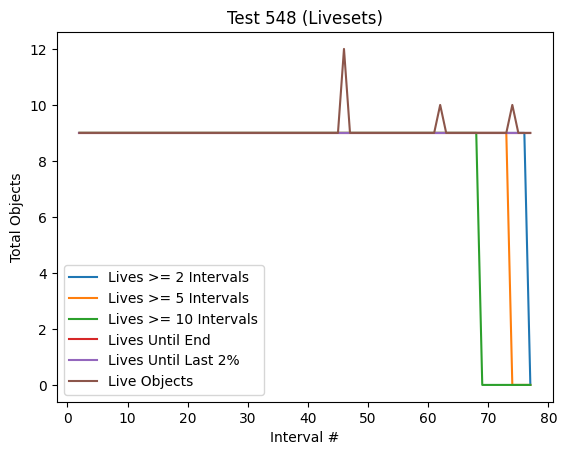

Test 549
Total objects for intervals: [13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
Total written for intervals: [13, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 21, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]
Total new for intervals: [13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

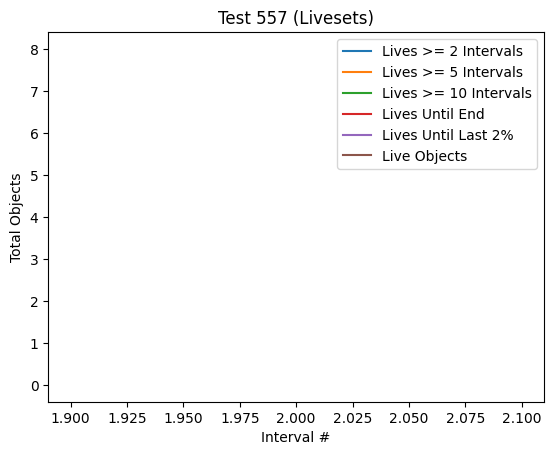

In [70]:
# Now that we have the data, we can graph it
# For each test, we want to graph the following (with the interval # as the x-axis):
#   - The total number of objects (as the y-axis) subdivided into the following categories:
#      - Total number of objects
#      - New objects that interval
#      - Objects that were written to that interval
#
# The graph should be a stacked bar graph, with a segment for each object colored by the category it falls into
# The brightness of each segment should be proportional to the amount of memory saved by compressing the physical pages
# Draw a line through the segments corresponding to each object to show how long the object lived for

for test_number, allocation_data in test_allocation_data.items():
    try:
        # Get the data for each object
        objects = set()
        for allocation in allocation_data.values():
            for o in allocation.get_objects():
                objects.add(o)
        print("Test " + str(test_number))
        object_data = pd.DataFrame()

        if len(objects) == 0:
            print("No objects to process for test " + str(test_number))
            continue

        min_interval = int(all_data[test_number]["Interval #"].min())
        max_interval = int(all_data[test_number]["Interval #"].max())

        total_objects = [
            sum([1 for o in objects if o.get_first_interval() <= i and o.get_last_interval() >= i]) for i in range(min_interval, max_interval + 1)
        ]
        total_written = [
            sum([1 for o in objects if o.was_written_to_during_interval(i)]) for i in range(min_interval, max_interval + 1)
        ]
        total_new = [
            sum([1 for o in objects if o.get_first_interval() == i]) for i in range(min_interval, max_interval + 1)
        ]

        print("Total objects for intervals: " + str(total_objects))
        print("Total written for intervals: " + str(total_written))
        print("Total new for intervals: " + str(total_new))

        # Just do the top 1000 sized objects
        print("Tracked " + str(len(objects)) + " objects")
        max_tracked = 250
        print(f"Sorting objects by size and truncating to {max_tracked}...")
        objects = sorted(objects, key=lambda o: o.get_physical_size_in_bytes(), reverse=True)[:max_tracked]
        for i, o in enumerate(objects):
            percent_done = (int(i + 1) * 100 / len(objects))
            if percent_done % 10 == 0:
                print(str(percent_done) + "% done") 

            savings = [
                row["Object Physical Page Compression Savings (bytes)"] for row in o.data
            ]
            savings_without_writes = [
                row["Object Physical Page Compression Savings (bytes)"] if not row["Written During This Interval?"] else 0 for row in o.data
            ]
            
            since_last_write = [i - o.get_interval_of_last_write(i) for i in range(o.get_first_interval(), o.get_last_interval() + 1)]
            # print("First interval: " + str(o.get_first_interval()))
            # print("Last interval: " + str(o.get_last_interval()))
            object_data = pd.concat([object_data, pd.DataFrame({
                "Interval #": [row["Interval #"] for row in o.data],
                "Is Live": [1 if o.get_first_interval() <= row["Interval #"] and o.get_last_interval() >= row["Interval #"] else 0 for row in o.data],
                # The number of intervals remaining in this object's lifetime
                "Intervals Remaining": [o.get_last_interval() - row["Interval #"] if o.get_last_interval() > row["Interval #"] else 0 for row in o.data],
                "Lives Just This Interval": [1 if o.get_first_interval() == row["Interval #"] and o.get_last_interval() == row["Interval #"] else 0 for row in o.data],
                "Lives >= 1 Interval": [1 if o.get_last_interval() - row["Interval #"] >= 0 else 0 for row in o.data],
                "Lives >= 2 Intervals": [1 if o.get_last_interval() - row["Interval #"] >= 1 else 0 for row in o.data], # or o.get_last_interval() == max_interval
                "Lives >= 5 Intervals": [1 if o.get_last_interval() - row["Interval #"] >= 4 else 0 for row in o.data], # or o.get_last_interval() == max_interval
                "Lives >= 10 Intervals": [1 if o.get_last_interval() - row["Interval #"] >= 9  else 0 for row in o.data], # or o.get_last_interval() == max_interval
                # Does this object live until the end of the test?
                "Lives Until End": [1 if o.get_last_interval() == max_interval else 0 for row in o.data],
                # Does this object live until last 2% of the test?
                "Lives Until Last 2%": [1 if o.get_last_interval() >= max_interval - (max_interval * 0.02) else 0 for row in o.data],
                "Lives Until Last 1%": [1 if o.get_last_interval() >= max_interval - (max_interval * 0.01) else 0 for row in o.data],
                
                "Total Objects": [total_objects[row["Interval #"] - min_interval] for row in o.data],
                "Total Written": [total_written[row["Interval #"] - min_interval] for row in o.data],
                "Total New": [total_new[row["Interval #"] - min_interval] for row in o.data],
                "Written": [int(row["Written During This Interval?"]) for row in o.data],
                "New": [int(row["Is new?"]) for row in o.data],
                "Percent Savings": [
                    # Zero if the object was written to, otherwise the amount of memory saved by compressing the physical pages
                    row["Object Physical Page Compression Savings (bytes)"] / row["Object Physical Size (bytes)"] if not row["Written During This Interval?"] else 0 for row in o.data
                ],
                "Savings": savings,
                "Savings Without Writes": savings_without_writes,
                # "Since Last Write * Savings": [prod(x) for x in zip(since_last_write, savings_without_writes)],
                "Since Last Write": since_last_write,
                "Longest Clean Streak": o.get_longest_lifetime_without_write(),
                "Clean Streak Savings": o.get_average_compression_during_longest_lifetime_without_write_in_bytes(),
                "Age": [row["Age (intervals)"] for row in o.data],
                "Object": repr(o),
                "Site": o.get_site(),
            })])
        print("Done processing data for test " + str(test_number))
        print("Graphing data...")

        # Plot the data
        # sns.barplot(x="Interval #", y="Total Objects", data=object_data, color="green", legend="full")
        # sns.barplot(x="Interval #", y="Total Written", data=object_data, color="red", legend="full")
        # sns.barplot(x="Interval #", y="Total New", data=object_data, color="blue", legend="full")

        # Create a multibar plot
        '''
        plt.figure(figsize=(20,10))
        plt.title("Test " + str(test_number))
        total_obj = sns.barplot(x="Interval #", y="Total Objects", data=object_data, color="green", label="Total Objects")
        total_hot = sns.barplot(x="Interval #", y="Total Written", data=object_data, color="red", label="Total Written")
        total_new = sns.barplot(x="Interval #", y="Total New", data=object_data, color="blue", label="Total New")
        # plt.legend(handles=[total_obj, total_hot, total_new], labels=["Total Objects", "Total Written", "Total New"])
        print("Done with first graph, moving on to the next...")
        plt.show()
        # Show
        # sns.barplot(x="Interval #", y="Percent Savings", data=object_data, color="green", ax=ax)
        # sns.lineplot(x="Interval #", y="Written", data=object_data, ax=ax)
        plt.figure(figsize=(20,20))
        g = sns.relplot(
            data=object_data,
            x="Interval #", y="Since Last Write", kind="line", hue="Object", size="Savings", style="Written", markers=True, dashes=False
        )
        # Set the title
        g.fig.suptitle("Test " + str(test_number))
        # plt.legend()
        print("Done with second graph, moving on to the next...")
        plt.show()

        plt.figure(figsize=(20,20))
        g = sns.relplot(
            data=object_data,
            x="Interval #", y="Since Last Write", kind="line", hue="Site", size="Savings", style="Written", markers=True, dashes=False
        )
        g.fig.suptitle("Test " + str(test_number))
        # plt.legend()
        print("Done with third graph, moving on to the next...")
        plt.show()

        plt.figure(figsize=(20,20))
        plt.title("Test " + str(test_number))
        for o in objects:
            sns.lineplot(x="Interval #", y="Savings", data=object_data[object_data["Object"] == repr(o)], label=repr(o), style="Written", legend=False, markers={1: "X", 0: "D"}, dashes=False)
        print("Done with fourth graph, moving on to the next...")
        plt.show()

        plt.figure(figsize=(20,20))
        plt.title("Test " + str(test_number))
        for o in objects:
            sns.lineplot(x="Interval #", y="Savings Without Writes", data=object_data[object_data["Object"] == repr(o)], label=repr(o), markers=True, dashes=False)
        print("Done with fifth graph, moving on to the next...")
        plt.show()
        '''
        
        # plt.figure(figsize=(20,10))
        plt.figure()
        plt.title("Test " + str(test_number) + " (Livesets)")
        # Show a lineplot of different categories of livesets
        # One line for the total number of objects
        
        # Sum all the objects that live for the next interval
        # next_interval = object_data.groupby("Interval #")["Lives >= 1 Interval"].sum()
        # sns.lineplot(x=next_interval.index, y=next_interval, label="Lives >= 1 Interval")
        # Sum all the objects that live for the next two intervals
        next_two_intervals = object_data.groupby("Interval #")["Lives >= 2 Intervals"].sum()
        sns.lineplot(x=next_two_intervals.index, y=next_two_intervals, label="Lives >= 2 Intervals")
        # Sum all the objects that live for the next five intervals
        next_five_intervals = object_data.groupby("Interval #")["Lives >= 5 Intervals"].sum()
        sns.lineplot(x=next_five_intervals.index, y=next_five_intervals, label="Lives >= 5 Intervals")
        # Sum all the objects that live for the next ten intervals
        next_ten_intervals = object_data.groupby("Interval #")["Lives >= 10 Intervals"].sum()
        sns.lineplot(x=next_ten_intervals.index, y=next_ten_intervals, label="Lives >= 10 Intervals")
        # Sum all the objects that live until the end of the test
        until_end = object_data.groupby("Interval #")["Lives Until End"].sum()
        sns.lineplot(x=until_end.index, y=until_end, label="Lives Until End")
        # Sum all the objects that live until the last 2% of the test
        until_last = object_data.groupby("Interval #")["Lives Until Last 2%"].sum()
        sns.lineplot(x=until_last.index, y=until_last, label="Lives Until Last 2%")
        # next_interval = object_data.groupby("Interval #")["Lives Just This Interval"].sum()
        # sns.lineplot(x=next_interval.index, y=next_interval, label="Lives Just This Interval")
        
        
        is_live = object_data.groupby("Interval #")["Is Live"].sum()
        sns.lineplot(x=is_live.index, y=is_live, label="Live Objects")
        
        # Set the x-axis label
        plt.xlabel("Interval #")
        # Set the y-axis label
        plt.ylabel("Total Objects")
        plt.legend()
        print("Done with sixth graph, moving on to the next...")
        plt.show()
        
    except Exception as e:
        print("Error processing test " + str(test_number) + ": " + str(e))
        continue